In [3]:
from scipy import io
from scipy.signal import butter, lfilter
import h5py
import random
import numpy as np
import os

In [4]:
datafolder = "data/"

In [5]:
def butter_bandpass(lowcut, highcut, sampling_rate, order=5):
    nyq_freq = sampling_rate*0.5
    low = lowcut/nyq_freq
    high = highcut/nyq_freq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_high_low_pass(lowcut, highcut, sampling_rate, order=5):
    nyq_freq = sampling_rate*0.5
    lower_bound = lowcut/nyq_freq
    higher_bound = highcut/nyq_freq
    b_high, a_high = butter(order, lower_bound, btype='high')
    b_low, a_low = butter(order, higher_bound, btype='low')
    return b_high, a_high, b_low, a_low

def butter_bandpass_filter(data, lowcut, highcut, sampling_rate, order=5, how_to_filt = 'separately'):
    if how_to_filt == 'separately':
        b_high, a_high, b_low, a_low = butter_high_low_pass(lowcut, highcut, sampling_rate, order=order)
        y = lfilter(b_high, a_high, data)
        y = lfilter(b_low, a_low, y)
    elif how_to_filt == 'simultaneously':
        b, a = butter_bandpass(lowcut, highcut, sampling_rate, order=order)
        y = lfilter(b, a, data)
    return y

def open_eeg_mat(filename, centered=True):
    all_data = io.loadmat(filename)
    eeg_data = all_data['data_cur']
    if centered:
        eeg_data = eeg_data - np.mean(eeg_data,1)[np.newaxis].T
        print('Data were centered: channels are zero-mean')
    states_labels = all_data['states_cur']
    states_codes = list(np.unique(states_labels)[:])
    sampling_rate = all_data['srate']
    chan_names = all_data['chan_names']
    return eeg_data, states_labels, sampling_rate, chan_names, eeg_data.shape[0], eeg_data.shape[1], states_codes

In [6]:
train_datas = {}
test_datas = {}
truetest_datas = {}

def to_onehot(label):
    labels_encoding = {1: np.array([1,0,0]), 2: np.array([0,1,0]), 6: np.array([0,0,1])}
    return labels_encoding[label]

for fname in os.listdir(datafolder):
    filename = datafolder + fname
    [eeg_data, states_labels, sampling_rate, chan_names, chan_numb, samp_numb, states_codes] = open_eeg_mat(filename, centered=False)
    sampling_rate = sampling_rate[0,0]
    eeg_data = butter_bandpass_filter(eeg_data, 0.5, 45, sampling_rate, order=5, how_to_filt = 'simultaneously')
    
    states_labels = states_labels[0]
    print(states_labels)
    states_labels = states_labels[2000:-2000]
    eeg_data = eeg_data[:,2000:-2000]
    
    experiment_name = "_".join(fname.split("_")[:-1])
    if fname.endswith("_2.mat"):
        test_datas[experiment_name] = {"eeg_data": eeg_data.T, "labels": states_labels}
    elif fname.endswith("_1.mat"):
        train_datas[experiment_name] = {"eeg_data": eeg_data.T, "labels": states_labels}
    elif fname.endswith("_2test.mat"):
        truetest_datas[experiment_name] = {"eeg_data": eeg_data.T, "labels": states_labels}

[1 1 1 ..., 6 6 6]
[1 1 1 ..., 6 6 6]
[1 1 1 ..., 6 6 6]


In [7]:
# separate scaling for each user, should not hurt 
from sklearn.preprocessing import StandardScaler

for key in train_datas.keys():
    sc = StandardScaler()
    train_datas[key]["eeg_data"] = sc.fit_transform(train_datas[key]["eeg_data"])
    test_datas[key]["eeg_data"] = sc.transform(test_datas[key]["eeg_data"])
    truetest_datas[key]["eeg_data"] = sc.transform(truetest_datas[key]["eeg_data"])

In [8]:
slice_len = 500

In [9]:
def generate_slice(test=False):
    if test:
        experiment_data = random.choice(list(test_datas.values()))
    else:
        experiment_data = random.choice(list(train_datas.values()))
    
    X = experiment_data["eeg_data"]
    y = experiment_data["labels"]
    
    while True:
        slice_start = np.random.choice(len(X) - slice_len)
        slice_end = slice_start + slice_len
        slice_x = X[slice_start:slice_end]
        #slice_x = normalize(slice_x)
        slice_y = y[slice_start:slice_end]
        
        if len(set(slice_y)) == 1:
            return slice_x, to_onehot(slice_y[-1])

In [10]:
generate_slice()[0].shape

(500, 24)

In [11]:
def data_generator(batch_size, test=False):
    while True:
        batch_x = []
        batch_y = []
        
        for i in range(0, batch_size):
            x, y = generate_slice(test=test)
            batch_x.append(x)
            batch_y.append(y)
            
        y = np.array(batch_y)
        x = np.array([i for i in batch_x])
        yield (x, y)

In [12]:
from keras.layers import Convolution1D, Dense, Dropout, Input, merge, GlobalMaxPooling1D, MaxPooling1D, Flatten, LSTM
from keras.models import Model, load_model
from keras.optimizers import RMSprop

In [13]:
def get_base_model(input_len, fsize):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_seq = Input(shape=(input_len, 24))
    nb_filters = 50
    convolved = Convolution1D(nb_filters, 5, border_mode="same", activation="tanh")(input_seq)
    pooled = GlobalMaxPooling1D()(convolved)
    compressed = Dense(20, activation="linear")(pooled)
    compressed = Dropout(0.3)(compressed)
    compressed = Dense(20, activation="relu")(compressed)
    compressed = Dropout(0.3)(compressed)
    model = Model(input=input_seq, output=compressed)            
    return model

In [14]:
slice_len

500

In [12]:
input1125_seq = Input(shape=(slice_len, 24))

base_network1125 = get_base_model(slice_len, 10)

embedding_1125 = base_network1125(input1125_seq)
out = Dense(3, activation='softmax')(embedding_1125)
    
model = Model(input=input1125_seq, output=out)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(50, 5, activation="tanh", padding="same")`
  
C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("dr...)`
  if sys.path[0] == '':
C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [140]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

nb_epoch = 100000
earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')
checkpointer = ModelCheckpoint("convlstm_alldata.h5", monitor='val_categorical_accuracy', verbose=1,
                               save_best_only=True, mode='auto', period=1)

samples_per_epoch = 15000
nb_epoch = 10

history = model.fit_generator(data_generator(batch_size=25), samples_per_epoch, nb_epoch, 
                    callbacks=[earlyStopping, checkpointer], verbose=1, nb_val_samples=5000, 
                    validation_data=data_generator(batch_size=25, test=True))

C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 15000, 10, callbacks=[<keras.ca..., verbose=1, validation_data=<generator..., validation_steps=5000)`
  del sys.path[0]


Epoch 1/10
15000/15000 [==============================] - 179s - loss: 0.0764 - categorical_accuracy: 0.9728 - val_loss: 1.8573 - val_categorical_accuracy: 0.7260
Epoch 2/10
15000/15000 [==============================] - 174s - loss: 0.0253 - categorical_accuracy: 0.9923 - val_loss: 1.5765 - val_categorical_accuracy: 0.7592
Epoch 3/10
15000/15000 [==============================] - 175s - loss: 0.0211 - categorical_accuracy: 0.9938 - val_loss: 0.9901 - val_categorical_accuracy: 0.8063
Epoch 4/10
15000/15000 [==============================] - 171s - loss: 0.0168 - categorical_accuracy: 0.9952 - val_loss: 1.5931 - val_categorical_accuracy: 0.7709
Epoch 5/10
15000/15000 [==============================] - 175s - loss: 0.0164 - categorical_accuracy: 0.9952 - val_loss: 1.2390 - val_categorical_accuracy: 0.7915
Epoch 6/10
15000/15000 [==============================] - 180s - loss: 0.0129 - categorical_accuracy: 0.9962 - val_loss: 0.5813 - val_categorical_accuracy: 0.8811
Epoch 7/10
15000/15000

In [141]:
print(history.history.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

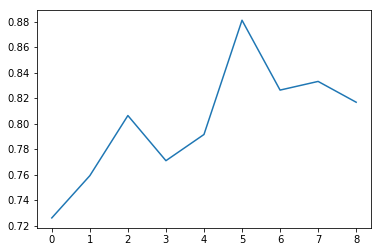

In [143]:
plt.plot(history.history['val_categorical_accuracy'])

In [16]:
model = load_model('convlstm_alldata.h5');

## Test visualization

In [17]:
model.layers

In [18]:
from matplotlib import pyplot as plt

from vis.utils import utils
from vis.utils.vggnet import VGG16
from vis.visualization import visualize_class_activation


# Build the VGG16 network with ImageNet weights
#model = VGG16(weights='imagenet', include_top=True)
#print('Model loaded.')

# The name of the layer we want to visualize
# (see model definition in vggnet.py)
layer_name = 'dense_6'
layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

# Generate three different images of the same output index.
vis_images = []
for idx in [20, 20, 20]:
    img = visualize_class_activation(model, layer_idx, filter_indices=idx, max_iter=500)
    img = utils.draw_text(img, str(idx))
    vis_images.append(img)

stitched = utils.stitch_images(vis_images)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()


ValueError: slice index 20 of dimension 1 out of bounds. for 'strided_slice' (op: 'StridedSlice') with input shapes: [?,3], [2], [2], [2] and with computed input tensors: input[1] = <0 20>, input[2] = <0 21>, input[3] = <1 1>.

NameError: name 'visualize_class_activation' is not defined

In [15]:
from vis.losses import ActivationMaximization
from vis.regularizers import TotalVariation, LPNorm
from vis.modifiers import Jitter
from vis.optimizer import Optimizer

from vis.callbacks import GifGenerator
from vis.utils.vggnet import VGG16

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 500, 24)           0         
_________________________________________________________________
model_3 (Model)              (None, 20)                7490      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 63        
Total params: 7,553
Trainable params: 7,553
Non-trainable params: 0
_________________________________________________________________


In [29]:
layer_name = 'dense_6'

In [30]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
output_class = [20]

losses = [
    (ActivationMaximization(layer_dict[layer_name], output_class), 2),
    (LPNorm(model.input), 10),
    (TotalVariation(model.input), 10)
]
opt = Optimizer(model.input, losses)
opt.minimize(max_iter=500, verbose=True, image_modifiers=[Jitter()], callbacks=[GifGenerator('opt_progress')])

ValueError: slice index 20 of dimension 1 out of bounds. for 'strided_slice_1' (op: 'StridedSlice') with input shapes: [?,3], [2], [2], [2] and with computed input tensors: input[1] = <0 20>, input[2] = <0 21>, input[3] = <1 1>.

In [15]:
filename = 'data/ksenia_long_2test'
#filename = 'data/ksenia_long_1'
[eeg_data, states_labels, sampling_rate, chan_names, chan_numb, samp_numb, states_codes] = open_eeg_mat(filename, centered=False)
sampling_rate = sampling_rate[0,0]
eeg_data = butter_bandpass_filter(eeg_data, 0.5, 45, sampling_rate, order=5, how_to_filt = 'simultaneously')

states_labels = states_labels[0]
print(states_labels)
states_labels = states_labels[2000:-2000]
eeg_data = eeg_data[:,2000:-2000]



[1 1 1 ..., 6 6 6]


In [23]:
truetest_datas

{'ksenia_long': {'eeg_data': array([[  0.72886774,   0.28953301,  -0.06310475, ...,  -0.84023706,
           -0.5951511 ,  14.67372102],
         [  0.40641331,   0.01874414,  -0.37925777, ...,  -0.82688436,
           -0.5592863 ,  15.00637087],
         [  0.09576368,  -0.24521609,  -0.66651021, ...,  -0.71990772,
           -0.42063431,  15.3341146 ],
         ..., 
         [ -0.49877598,  -0.79176197,  -1.56604115, ...,   0.55407907,
            0.35563988,  -0.02974017],
         [ -0.07212109,  -0.34952697,  -1.31718183, ...,   0.39177637,
            0.15897734,  -0.02973893],
         [  0.38851491,   0.19016002,  -0.7966039 , ...,   0.11234432,
           -0.13938467,  -0.02973764]]),
  'labels': array([1, 1, 1, ..., 6, 6, 6], dtype=uint8)}}

In [49]:
eeg_data = truetest_datas['ksenia_long']['eeg_data'].T
idxs = np.arange(0,eeg_data.shape[1],500)
num_chunks = idxs.shape[0]
num_chunks

127

In [50]:
chunks = np.zeros([num_chunks-1,24,500])
preds = np.zeros([num_chunks-1,3])

for i in range(num_chunks-1):
    #print(idxs[i])
    chunk = eeg_data[:,idxs[i]:(idxs[i]+500)].T
    chunks[i,:,:] = chunk.T
    preds[i] = model.predict(chunk[None,:,:,])


In [59]:
preds.shape

(126, 3)

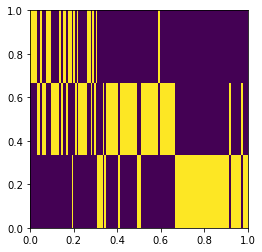

In [51]:
a = np.argmax(preds,axis=1)


a_bin = np.zeros([3,a.shape[0]])

a_bin[0,:] = (a == 0)
a_bin[1,:] = (a == 1)
a_bin[2,:] = (a == 2)
              
plt.imshow(a_bin, extent=[0, 1, 0, 1])

In [52]:
a.shape

(126,)

In [53]:
true_labels = eeg_data = truetest_datas['ksenia_long']['labels']
true_labels = true_labels[::500]
true_labels = true_labels[0:-1]
true_labels.shape


(126,)

In [54]:
true_labels_bin = np.zeros([3,true_labels.shape[0]])
true_labels_bin.shape


(3, 126)

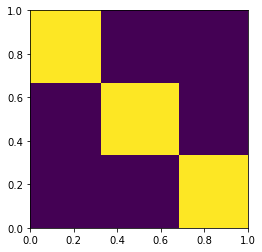

In [55]:

true_labels_bin[0,:] = (true_labels == 1)
true_labels_bin[1,:] = (true_labels == 2)
true_labels_bin[2,:] = (true_labels == 6)

plt.imshow(true_labels_bin, extent=[0, 1, 0, 1])

In [56]:
from sklearn.metrics import roc_auc_score

In [86]:
score1 = roc_auc_score(true_labels_bin,a_bin)

In [87]:
score1

0.80952380952380953

In [88]:
predsT = preds.T;

In [89]:
score2 = roc_auc_score(true_labels_bin,predsT)

In [90]:
score2

0.86111111111111116

In [82]:
true_labels_bin[:,0].shape

(3,)

In [76]:
true_labels_bin[:,0]

array([ 1.,  0.,  0.])

In [64]:
preds.shape

(126, 3)

In [71]:
true_labels_bin.shape

(3, 126)

In [67]:
type(preds[1,1])

numpy.float64

In [79]:
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
roc_auc_score(y_true, y_scores)

0.75

In [80]:
y_true.shape

(4,)

In [68]:
type(y_scores[1])

numpy.float64

In [19]:
a

array([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 2, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 2, 2, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2], dtype=int64)

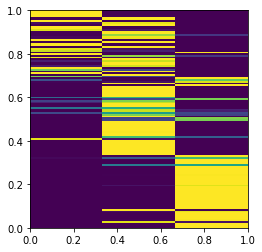

In [22]:
plt.imshow(preds, extent=[0, 1, 0, 1])